In [15]:
import pandas as pd
HORIZON_DAYS=252
df_raw = pd.read_excel("congress-trading-all.xlsx")

print("Shape:", df_raw.shape)
print("\nColumns:")
print(df_raw.columns)
print("\nFirst rows:")
df_raw.head()


Shape: (108443, 20)

Columns:
Index(['Ticker', 'TickerType', 'Company', 'Traded', 'Transaction',
       'Trade_Size_USD', 'Status', 'Subholding', 'Description', 'Name',
       'BioGuideID', 'Filed', 'Party', 'District', 'Chamber', 'Comments',
       'Quiver_Upload_Time', 'excess_return', 'State', 'last_modified'],
      dtype='object')

First rows:


,Ticker,TickerType,Company,Traded,Transaction,Trade_Size_USD,Status,Subholding,Description,Name,BioGuideID,Filed,Party,District,Chamber,Comments,Quiver_Upload_Time,excess_return,State,last_modified
0,"3.MONTH, MATURE",GS,TREASURY BILL,2025-12-23,Purchase,"$15,001 - $50,000",NEW,SCHWAB (FORMERLY TD AMERITRADE),NaN,Rudy C. Yakym Iii,Y000067,2025-12-23,R,IN02,House,NaN,2025-12-24,NaN,Indiana,2025-12-24
1,CBRL,ST,"CRACKER BARREL OLD COUNTRY STORE, INC. - COMMO...",2025-12-16,Purchase,"$15,001 - $50,000",NEW,NaN,NaN,Tim Moore,M001236,2025-12-19,R,NC14,House,NaN,2025-12-22,0.348618,North Carolina,2025-12-22
2,GOOGL,ST,ALPHABET INC. - CLASS A COMMON STOCK,2025-12-15,Purchase,"$15,001 - $50,000",NEW,MORGAN STANLEY - E*TRADE #2,NaN,Cleo Fields,F000110,2025-12-17,D,LA06,House,NaN,2025-12-18,-1.237764,Louisiana,2025-12-18
3,GOOG,ST,ALPHABET INC. - CLASS C CAPITAL STOCK,2025-12-15,Purchase,"$1,001 - $15,000",NEW,MORGAN STANLEY - E*TRADE #2,NaN,Cleo Fields,F000110,2025-12-17,D,LA06,House,NaN,2025-12-18,-1.169693,Louisiana,2025-12-18
4,SOUN,ST,"SOUNDHOUND AI, INC. - CLASS A COMMON STOCK",2025-12-15,Sale,"$1,001 - $15,000",NEW,MORGAN STANLEY - E*TRADE #2,NaN,Cleo Fields,F000110,2025-12-17,D,LA06,House,NaN,2025-12-18,1.557815,Louisiana,2025-12-18


In [33]:
cols_keep = [
    'Ticker',
    'Traded',
    'Transaction',
    'Trade_Size_USD',
    'Party',
    'Chamber',
    'State'
]

df = df_raw[cols_keep].copy()
print(df.shape)
df.head()


df = df[df['Transaction'].str.contains('Purchase', case=False, na=False)].copy()
print("After Purchase filter:", df.shape)

"""
We only deal with purchases. """

df['Traded'] = pd.to_datetime(df['Traded'], errors='coerce')
df = df.dropna(subset=['Traded'])
print("After date cleaning:", df.shape)

"""
I convert transaction dates to a standard datetime format and remove records with invalid or missing dates,
  as post transaction return calculations require a well-defined event date.”

"""

# Restrict analysis period to ensure sufficient data density
df = df[(df['Traded'] >= '2014-01-01') & (df['Traded'] <= '2024-01-01')].copy()
print("After date window filter:", df.shape)


df = df[df['Ticker'].notna()]
df = df[df['Ticker'].str.len() <= 5]
print("After ticker cleaning:", df.shape)

"""I cleaned Tickers which has more than 5 letters in order to eliminate non-stock tickers"""

df_raw['Party'].value_counts().head(20)
# Normalize Party labels
df['Party'] = df['Party'].astype(str).str.strip()

party_map = {
    'D': 'Democrat',
    'R': 'Republican',
    'I': 'Independent',
    'DEM': 'Democrat',
    'REP': 'Republican',
    'Democratic': 'Democrat',
    'Republican': 'Republican'
}

df['Party_std'] = df['Party'].replace(party_map)

# Keep only the two major parties for this phase
df = df[df['Party_std'].isin(['Democrat', 'Republican'])].copy()
print("After party standardization:", df.shape)


# Subsample for return-based analysis (API efficiency)
df_sample = df.sample(n=3000, random_state=42).copy()

print("Subsample shape:", df_sample.shape)
print(df_sample[['Ticker', 'Traded', 'Party_std']].head())


# --- Ticker normalization for yfinance ---
df_sample['Ticker'] = df_sample['Ticker'].astype(str).str.strip()


# Common Yahoo Finance symbol fixes
ticker_map = {
    'BRK.B': 'BRK-B',
    'BRK.A': 'BRK-A',
    'BF.B': 'BF-B',
    'BF.A': 'BF-A',
}

df_sample['Ticker_yf'] = df_sample['Ticker'].replace(ticker_map)


(108443, 7)
After Purchase filter: (54857, 7)
After date cleaning: (54857, 7)
After date window filter: (44968, 7)
After ticker cleaning: (44764, 7)
After party standardization: (44736, 8)
Subsample shape: (3000, 8)
      Ticker     Traded   Party_std
88443  BRK.B 2017-02-23    Democrat
90067    RTN 2016-12-15  Republican
42404   HNDL 2021-07-01  Republican
76839    HSY 2018-05-15    Democrat
34243    CDW 2022-06-03  Republican


In [31]:
print("Earliest trade date:", df['Traded'].min())
print("Latest trade date:", df['Traded'].max())
df['Year'] = df['Traded'].dt.year
print(df['Year'].value_counts().sort_index())
df['Year'] = df['Traded'].dt.year


Earliest trade date: 2014-01-02 00:00:00
Latest trade date: 2023-12-29 00:00:00
Year
2014    2763
2015    2653
2016    3857
2017    4696
2018    6307
2019    5366
2020    6238
2021    3513
2022    4974
2023    4369
Name: count, dtype: int64


In [21]:
tickers = df_sample['Ticker_yf'].unique().tolist()
print("Number of unique tickers:", len(tickers))



import yfinance as yf

def compute_forward_return(price_series, event_date, HORIZON_DAYS=252):
    """
    price_series: pandas Series with DatetimeIndex
    event_date: datetime of transaction
    horizon: days forward
    """
    try:
        price_series = price_series.sort_index()
        event_date = pd.to_datetime(event_date)

        if event_date not in price_series.index:
            # get next trading day
            event_date = price_series.index[price_series.index.get_loc(event_date, method='bfill')]

        end_date = event_date + pd.Timedelta(days=HORIZON_DAYS)
        end_date = price_series.index[price_series.index.get_loc(end_date, method='bfill')]

        start_price = price_series.loc[event_date]
        end_price = price_series.loc[end_date]

        return (end_price - start_price) / start_price
    except Exception:
        return None


Number of unique tickers: 1237


In [23]:
from tqdm import tqdm
import yfinance as yf

price_data = {}
failed = []

for ticker in tqdm(tickers):
    try:
        df_price = yf.download(
            ticker,
            start="2014-01-01",
            end="2026-12-31",
            progress=False,
            auto_adjust=True,
            threads=False
        )
        if df_price.empty or 'Close' not in df_price.columns:
            failed.append(ticker)
            continue
        price_data[ticker] = df_price['Close']
    except Exception:
        failed.append(ticker)

print("Downloaded price series:", len(price_data))
print("Failed tickers:", len(failed))
print("Examples:", failed[:20])


  0%|          | 1/1237 [00:01<23:32,  1.14s/it]$RTN: possibly delisted; no timezone found

1 Failed download:
['RTN']: possibly delisted; no timezone found
  1%|          | 13/1237 [00:06<08:13,  2.48it/s]HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: FCEA"}}}
$FCEA: possibly delisted; no timezone found

1 Failed download:
['FCEA']: possibly delisted; no timezone found
  2%|▏         | 20/1237 [00:10<07:54,  2.57it/s]$DJO: possibly delisted; no price data found  (1d 2014-01-01 -> 2026-12-31)

1 Failed download:
['DJO']: possibly delisted; no price data found  (1d 2014-01-01 -> 2026-12-31)
  2%|▏         | 21/1237 [00:10<06:37,  3.06it/s]$VBTX: possibly delisted; no timezone found

1 Failed download:
['VBTX']: possibly delisted; no timezone found
  2%|▏         | 30/1237 [00:14<07:58,  2.52it/s]$LABL: possibly delisted; no timezone found

1 Failed download:
['LABL']: possibly delisted; no timezone found
  3%|▎      

Downloaded price series: 964
Failed tickers: 273
Examples: ['RTN', 'FCEA', 'DJO', 'VBTX', 'LABL', 'SQ', 'VZ', 'FLT', 'TMK', 'WBA', 'HUD', 'EOAN', 'HCN', 'WDR', 'ATVI', 'BKI', 'LGF.B', 'WB1', 'CATM', 'GLOP']


In [25]:
spy_prices = yf.download(
    "SPY",
    start="2014-01-01",
    end="2025-03-01",
    progress=False,
    auto_adjust=True,
    threads=False
)['Close']

print("SPY points:", len(spy_prices))
print("SPY range:", spy_prices.index.min(), "->", spy_prices.index.max())


SPY points: 2807
SPY range: 2014-01-02 00:00:00 -> 2025-02-28 00:00:00


In [27]:
import pandas as pd
import numpy as np

def forward_return(price_series, event_date, HORIZON_DAYS=252):
    if price_series is None or len(price_series) == 0:
        return np.nan
    try:
        s = price_series.dropna().copy()
        s.index = pd.to_datetime(s.index)
        d0 = pd.to_datetime(event_date)

        # first trading day on/after event_date
        start_idx = s.index[s.index >= d0]
        if len(start_idx) == 0:
            return np.nan
        start_dt = start_idx[0]
        start_price = float(s.loc[start_dt].iloc[0])

        # first trading day on/after start_dt + horizon_days
        d1 = start_dt + pd.Timedelta(HORIZON_DAYS=252)
        end_idx = s.index[s.index >= d1]
        if len(end_idx) == 0:
            return np.nan
        end_dt = end_idx[0]
        end_price = float(s.loc[end_dt].iloc[0])

        return (end_price - start_price) / start_price
    except Exception:
        return np.nan


In [41]:
print("Ticker_yf in df_sample", "Ticker_yf" in df_sample.columns)



Ticker_yf in df_sample True


In [43]:
print("Trade date range in df_sample:", df_sample['Traded'].min(), "->", df_sample['Traded'].max())


Trade date range in df_sample: 2014-01-08 00:00:00 -> 2023-12-28 00:00:00


In [49]:
import pandas as pd
import numpy as np

def forward_return(price_series, trade_date, horizon_days=252):
    # price_series: pd.Series (index datetime, values prices)
    if price_series is None or len(price_series) == 0:
        return np.nan
    
    # trade_date: datetime
    trade_date = pd.to_datetime(trade_date)

    # tarihten sonraki ilk işlem gününü bul
    idx = price_series.index
    start_pos = idx.searchsorted(trade_date)

    # trade_date'ten sonra veri yoksa
    if start_pos >= len(price_series):
        return np.nan

    end_pos = start_pos + horizon_days

    # horizon kadar ileri gidemiyorsak
    if end_pos >= len(price_series):
        return np.nan

    start_price = price_series.iloc[start_pos].item()
    end_price   = price_series.iloc[end_pos].item()


    return (end_price - start_price) / start_price


# Hangi ticker kolonunu kullandığımızı belirle
ticker_col = "Ticker_yf" if "Ticker_yf" in df_sample.columns else "Ticker"
print("Using ticker column:", ticker_col)

# Match rate
match_rate = df_sample[ticker_col].isin(price_data.keys()).mean()
print("Match rate:", match_rate)

H = 252

# Returns
df_sample["Return_1y"] = df_sample.apply(
    lambda row: forward_return(price_data.get(row[ticker_col]), row["Traded"], horizon_days=H),
    axis=1
)

df_sample["SPY_1y_Return"] = df_sample["Traded"].apply(
    lambda d: forward_return(spy_prices, d, horizon_days=H)
)

df_sample["AdjReturn_1y"] = df_sample["Return_1y"] - df_sample["SPY_1y_Return"]

df_sample_clean = df_sample.dropna(subset=["AdjReturn_1y"]).copy()

print(df_sample_clean[["Return_1y","SPY_1y_Return","AdjReturn_1y"]].describe())
print("Non-NaN AdjReturn_1y:", df_sample_clean["AdjReturn_1y"].notna().sum(), "out of", len(df_sample))


Using ticker column: Ticker_yf
Match rate: 0.8413333333333334
         Return_1y  SPY_1y_Return  AdjReturn_1y
count  2470.000000    2470.000000   2470.000000
mean      0.151246       0.160804     -0.009557
std       0.456252       0.158529      0.406953
min      -1.011433      -0.192682     -1.350244
25%      -0.089729       0.055310     -0.216057
50%       0.095160       0.160394     -0.043047
75%       0.317757       0.242312      0.137776
max       7.425197       0.775045      7.047078
Non-NaN AdjReturn_1y: 2470 out of 3000


In [51]:

import numpy as np
from scipy import stats

x = df_sample_clean['AdjReturn_1y'].dropna().values
n = len(x)
mean = np.mean(x)
se = stats.sem(x)
ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)

print("n:", n)
print("mean:", mean)
print("95% CI:", (ci_low, ci_high))

d = mean / np.std(x, ddof=1)
print("Cohen's d:", d)


n: 2470
mean: -0.009557498960793423
95% CI: (-0.025614217700556142, 0.006499219778969294)
Cohen's d: -0.02348551165186519


In [53]:
from scipy import stats

dem = df_sample_clean[df_sample_clean['Party_std']=='Democrat']['AdjReturn_1y']
rep = df_sample_clean[df_sample_clean['Party_std']=='Republican']['AdjReturn_1y']

t2, p2 = stats.ttest_ind(dem, rep, equal_var=False)  # Welch t-test
print("Dem mean:", dem.mean(), "n:", len(dem))
print("Rep mean:", rep.mean(), "n:", len(rep))
print("t-stat:", t2)
print("p-value:", p2)


Dem mean: -0.015954958289438704 n: 1245
Rep mean: -0.0030555913165784287 n: 1225
t-stat: -0.786705043936163
p-value: 0.43153186031720325


In [55]:
print([c for c in df_sample_clean.columns if "Adj" in c or "Return" in c])


['Return_1y', 'SPY_1y_Return', 'AdjReturn_1y']


Has Party_std? True
Has AdjReturn_1y? True


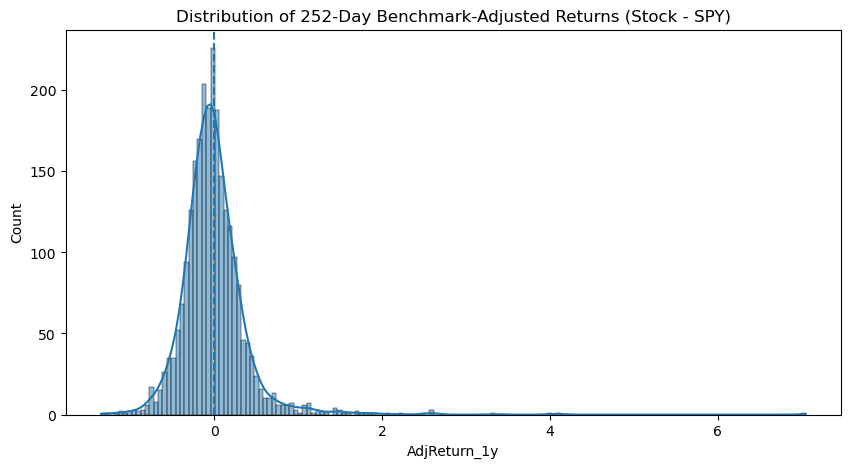

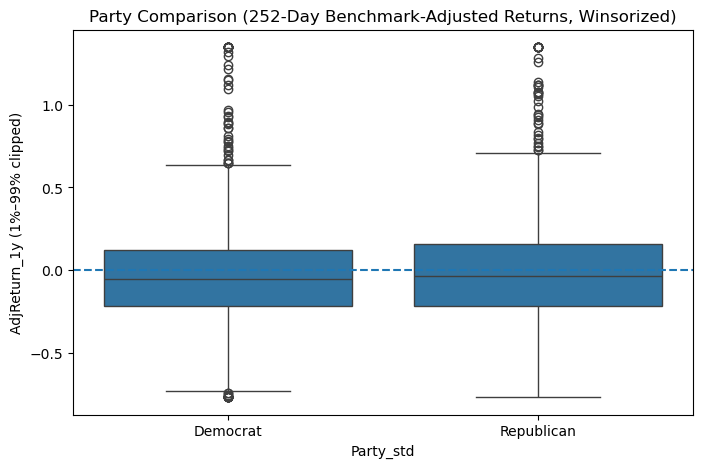

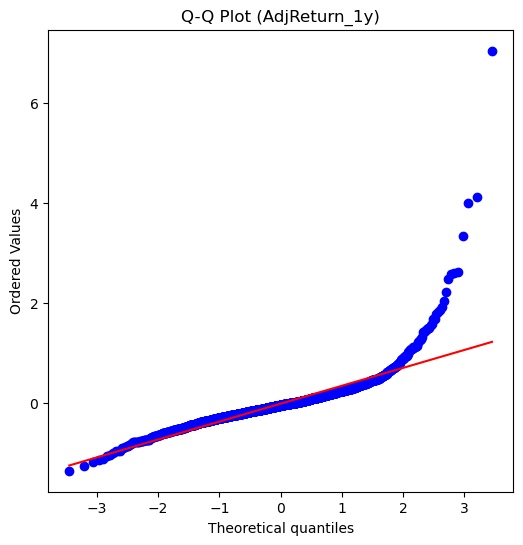

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 0) Kolon kontrol
print("Has Party_std?", "Party_std" in df_sample_clean.columns)
print("Has AdjReturn_1y?", "AdjReturn_1y" in df_sample_clean.columns)

# 1) Histogram
x = df_sample_clean["AdjReturn_1y"].dropna()

plt.figure(figsize=(10,5))
sns.histplot(x, kde=True)
plt.axvline(0, linestyle="--")
plt.title("Distribution of 252-Day Benchmark-Adjusted Returns (Stock - SPY)")
plt.xlabel("AdjReturn_1y")
plt.show()

# 2) Party boxplot

q_low, q_high = df_sample_clean["AdjReturn_1y"].quantile([0.01, 0.99])

df_plot = df_sample_clean.copy()
df_plot["AdjReturn_1y_w"] = df_plot["AdjReturn_1y"].clip(q_low, q_high)

plt.figure(figsize=(8,5))
sns.boxplot(data=df_plot, x="Party_std", y="AdjReturn_1y_w")
plt.axhline(0, linestyle="--")
plt.title("Party Comparison (252-Day Benchmark-Adjusted Returns, Winsorized)")
plt.ylabel("AdjReturn_1y (1%–99% clipped)")
plt.show()


# 3) Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(x, dist="norm", plot=plt)
plt.title("Q-Q Plot (AdjReturn_1y)")
plt.show()


In [75]:
import re
import numpy as np

def parse_trade_size(x):
    if pd.isna(x):
        return np.nan
    s = str(x)

    # bütün sayıları çek (virgül, $ vs temizle)
    nums = re.findall(r"\d[\d,]*", s)
    nums = [int(n.replace(",", "")) for n in nums]

    if len(nums) == 0:
        return np.nan
    if len(nums) == 1:
        return float(nums[0])
    # aralık varsa ortasını al
    return float(sum(nums[:2]) / 2)

df_sample_clean["Trade_Size_USD_num"] = df_sample_clean["Trade_Size_USD"].apply(parse_trade_size)

print(df_sample_clean[["Trade_Size_USD", "Trade_Size_USD_num"]].head(10))
print("Numeric conversion non-null:", df_sample_clean["Trade_Size_USD_num"].notna().mean())


          Trade_Size_USD  Trade_Size_USD_num
88443   $1,001 - $15,000              8000.5
42404   $1,001 - $15,000              8000.5
76839   $1,001 - $15,000              8000.5
34243   $1,001 - $15,000              8000.5
38511   $1,001 - $15,000              8000.5
57321   $1,001 - $15,000              8000.5
78327   $1,001 - $15,000              8000.5
29851  $15,001 - $50,000             32500.5
94274   $1,001 - $15,000              8000.5
48063   $1,001 - $15,000              8000.5
Numeric conversion non-null: 1.0


In [77]:
# =========================
# ML: Binary Classification
# Predict if a trade beats the market over 252 trading days
# Target = 1 if AdjReturn_1y > 0 else 0
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# 1) Build ML dataframe
ml_df = df_sample_clean.copy()

# Target: market outperformance
ml_df["Target"] = (ml_df["AdjReturn_1y"] > 0).astype(int)

# Features (keep it simple & defendable)
feature_cols = ["Trade_Size_USD_num", "Party_std", "Chamber", "State"]
ml_df = ml_df[feature_cols + ["Target"]].dropna(subset=["Target"]).copy()

X = ml_df[feature_cols]
y = ml_df["Target"]

print("ML dataset size:", len(ml_df))
print("Positive class rate (Target=1):", y.mean().round(3))

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# 3) Preprocess
numeric_features = ["Trade_Size_USD_num"]
categorical_features = ["Party_std", "Chamber", "State"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 4) Baseline model (majority class)
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)
base_proba = baseline.predict_proba(X_test)[:, 1] if hasattr(baseline.named_steps["model"], "predict_proba") else None

base_acc = accuracy_score(y_test, base_pred)
print("\n=== BASELINE (Majority Class) ===")
print("Accuracy:", round(base_acc, 4))
print("Confusion matrix:\n", confusion_matrix(y_test, base_pred))

# 5) Logistic Regression
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print("\n=== LOGISTIC REGRESSION ===")
print("Accuracy:", round(acc, 4))
print("ROC-AUC:", round(auc, 4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))

# 6) Quick interpretation helper
if auc < 0.55 and abs(acc - base_acc) < 0.02:
    print("\nInterpretation: Model performance is close to baseline/random. "
          "This suggests limited predictive signal in the chosen observable features, "
          "consistent with the statistical findings (returns centered near zero).")
else:
    print("\nInterpretation: Model shows some predictive power above baseline. "
          "We should examine feature importances/coefficients and validate robustness.")


ML dataset size: 2470
Positive class rate (Target=1): 0.427

=== BASELINE (Majority Class) ===
Accuracy: 0.5735
Confusion matrix:
 [[425   0]
 [316   0]]

=== LOGISTIC REGRESSION ===
Accuracy: 0.5668
ROC-AUC: 0.5
Confusion matrix:
 [[385  40]
 [281  35]]

Classification report:
               precision    recall  f1-score   support

           0     0.5781    0.9059    0.7058       425
           1     0.4667    0.1108    0.1790       316

    accuracy                         0.5668       741
   macro avg     0.5224    0.5083    0.4424       741
weighted avg     0.5306    0.5668    0.4811       741


Interpretation: Model performance is close to baseline/random. This suggests limited predictive signal in the chosen observable features, consistent with the statistical findings (returns centered near zero).
